In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers

Using TensorFlow backend.


The dataset contains 200,000 simulated cosmic ray air showers measured with a
surface detector of water Cherenkov tanks, such as the Pierre Auger Observatory.
The primary particles are protons with energies between 10^18.5 and 10^20 eV
and uniformly distributed arrival directions with a maximum zenith angle of 60 degrees.

Each detector station measures the following 2 quantities, which are stored in
form of a map (2D array) corresponding to the station positions in offset coordinates
- time: time point of detection in [s]
- signal: signal strength [arbitrary units]

The following shower properties need to be reconstructed
- showeraxis: x,y,z unit vector of the shower arrival direction
- showercore: position of the shower core in [m]
- logE: log10(energy / eV)

Your tasks are
 a) Complete the provided script to set up a multi-task regression network for
    simultaneously predicting all three shower properties. The network should
    consist of a part that is common to all three objectives, followed by an
    individual subnetwork / tower for each objective.
    As objectives you can use mean squared error.
 b) We want to train the network to the following precision (evaluation provided)
    - less than 1.5 degrees angular resolution
    - less than 25 m core position resolution
    - less than 10% relative energy uncertainty: (E_predicted - E_true) / E_true
    Estimate what these requirements mean in terms of mean squared error loss
    and adjust the relative weights of the objectives accordingly.
 c) Train your network to the above precision.
 d) Plot and interpret the training curve, both with and without the objective weights

In [2]:
# ---------------------------------------------------
# Load and prepare dataset - you can leave as is.
# ---------------------------------------------------
data = np.load('auger-shower-planar.npz')

# time map, values standard normalized with untriggered stations set to 0
T = data['time']
T -= np.nanmean(T)
T /= np.nanstd(T)
T[np.isnan(T)] = 0

# signal map, values normalized to range 0-1, untriggered stations set to 0
S = data['signal']
S = np.log10(S)
S -= np.nanmin(S)
S /= np.nanmax(S)
S[np.isnan(S)] = 0

# input features
X = np.stack([T, S], axis=-1)

# target features
# direction - x,y,z unit vector
y1 = data['showeraxis']

# core position - x,y [m]
y2 = data['showercore'][:, 0:2]
y2 /= 750

# energy - log10(E/eV) in range [18.5, 20]
y3 = data['logE']
y3 -= 19.25

# hold out the last 20000 events as test data
X_train, X_test = np.split(X, [-20000])
y1_train, y1_test = np.split(y1, [-20000])
y2_train, y2_test = np.split(y2, [-20000])
y3_train, y3_test = np.split(y3, [-20000])



In [3]:
# ----------------------------------------------------------------------
# Model & Training
# ----------------------------------------------------------------------
input1 = layers.Input(shape=(9, 9, 2, ))

# TODO: define a suitable network consisting of 2 parts:
# 1) a common network part (you can try a convolutional stack with ResNet- or
#    or DenseNet-like shortcuts)
z = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(input1)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(z)
z = layers.BatchNormalization()(z)
z = layers.LeakyReLU()(z)

# 2) separate network parts for the individual objectives

# First Network
z1 = layers.Conv2D(64, (3, 3), padding='valid', kernel_initializer='he_uniform')(z)
z1 = layers.BatchNormalization()(z1)
z1 = layers.LeakyReLU()(z1)

z1 = layers.Conv2D(64, (3, 3), padding='valid', kernel_initializer='he_uniform')(z1)
z1 = layers.BatchNormalization()(z1)
z1 = layers.LeakyReLU()(z1)
z1 = layers.Flatten()(z1)

# Second Network
z2 = layers.Conv2D(64, (3, 3), padding='valid', kernel_initializer='he_uniform')(z)
z2 = layers.BatchNormalization()(z2)
z2 = layers.LeakyReLU()(z2)

z2 = layers.Conv2D(64, (3, 3), padding='valid', kernel_initializer='he_uniform')(z2)
z2 = layers.BatchNormalization()(z2)
z2 = layers.LeakyReLU()(z2)
z2 = layers.Flatten()(z2)

# Third Network
z3 = layers.Conv2D(64, (3, 3), padding='valid', kernel_initializer='he_uniform')(z)
z3 = layers.BatchNormalization()(z3)
z3 = layers.LeakyReLU()(z3)

z3 = layers.Conv2D(64, (3, 3), padding='valid', kernel_initializer='he_uniform')(z3)
z3 = layers.BatchNormalization()(z3)
z3 = layers.LeakyReLU()(z3)
z3 = layers.Flatten()(z3)

# output Layer

output1 = layers.Dense(3, name='direction', kernel_initializer='he_uniform')(z1)
output2 = layers.Dense(2, name='core', kernel_initializer='he_uniform')(z2)
output3 = layers.Dense(1, name='energy', kernel_initializer='he_uniform')(z3)

model = keras.models.Model(inputs=input1, outputs=[output1, output2, output3])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 2)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 9, 32)     608         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 9, 9, 32)     128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 9, 9, 32)     0           batch_normalization_1[0][0]      
_____________________________________

In [4]:

model.compile(
    loss=['mse', 'mse', 'mse'],
    loss_weights=[1, 1, 1],  # you can give more weight to individual objectives
    optimizer=keras.optimizers.Adam(lr=1E-3))


In [5]:
fit = model.fit(X_train, [y1_train, y2_train, y3_train], 
                epochs=100, batch_size=64)

model.save('model-task2.h5')


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
180000/180000 [==============================] - 40s 223us/step - loss: 0.0470 - direction_loss: 0.0118 - core_loss: 0.0144 - energy_loss: 0.0208
Epoch 2/100
180000/180000 [==============================] - 38s 209us/step - loss: 0.0129 - direction_loss: 0.0030 - core_loss: 0.0030 - energy_loss: 0.0069
Epoch 3/100
180000/180000 [==============================] - 38s 209us/step - loss: 0.0088 - direction_loss: 0.0019 - core_loss: 0.0019 - energy_loss: 0.0050
Epoch 4/100
180000/180000 [==============================] - 38s 209us/step - loss: 0.0061 - direction_loss: 0.0012 - core_loss: 0.0014 - energy_loss: 0.0035
Epoch 5/100
180000/180000 [==============================] - 37s 208us/step - loss: 0.0047 - direction_loss: 9.5434e-04 - core_loss: 0.0011 - energy_loss: 0.0026
Epoch 6/100
180000/180000 [==============================] - 38s 209us/step - loss: 0.0035 - direction_loss: 6.8686e-04 - core_loss: 8.4283e-04 - energy_loss:

180000/180000 [==============================] - 37s 206us/step - loss: 8.5637e-04 - direction_loss: 9.5147e-05 - core_loss: 1.8855e-04 - energy_loss: 5.7268e-04
Epoch 48/100
180000/180000 [==============================] - 37s 205us/step - loss: 8.5206e-04 - direction_loss: 9.3897e-05 - core_loss: 1.8673e-04 - energy_loss: 5.7144e-04
Epoch 49/100
180000/180000 [==============================] - 37s 206us/step - loss: 8.4440e-04 - direction_loss: 9.2287e-05 - core_loss: 1.8406e-04 - energy_loss: 5.6805e-04
Epoch 50/100
180000/180000 [==============================] - 37s 206us/step - loss: 8.5035e-04 - direction_loss: 9.6135e-05 - core_loss: 1.8419e-04 - energy_loss: 5.7003e-04
Epoch 51/100
180000/180000 [==============================] - 37s 205us/step - loss: 8.3996e-04 - direction_loss: 9.1885e-05 - core_loss: 1.8250e-04 - energy_loss: 5.6558e-04
Epoch 52/100
180000/180000 [==============================] - 37s 205us/step - loss: 8.4134e-04 - direction_loss: 9.2108e-05 - core_loss: 

180000/180000 [==============================] - 37s 206us/step - loss: 7.4253e-04 - direction_loss: 7.3651e-05 - core_loss: 1.5336e-04 - energy_loss: 5.1552e-04
Epoch 94/100
180000/180000 [==============================] - 37s 206us/step - loss: 7.3925e-04 - direction_loss: 7.0394e-05 - core_loss: 1.5265e-04 - energy_loss: 5.1621e-04
Epoch 95/100
180000/180000 [==============================] - 37s 205us/step - loss: 7.3921e-04 - direction_loss: 7.3037e-05 - core_loss: 1.5135e-04 - energy_loss: 5.1483e-04
Epoch 96/100
180000/180000 [==============================] - 37s 205us/step - loss: 7.3610e-04 - direction_loss: 7.2826e-05 - core_loss: 1.5164e-04 - energy_loss: 5.1164e-04
Epoch 97/100
180000/180000 [==============================] - 37s 205us/step - loss: 7.2789e-04 - direction_loss: 6.9821e-05 - core_loss: 1.5186e-04 - energy_loss: 5.0621e-04
Epoch 98/100
180000/180000 [==============================] - 37s 205us/step - loss: 7.3305e-04 - direction_loss: 7.2735e-05 - core_loss: 

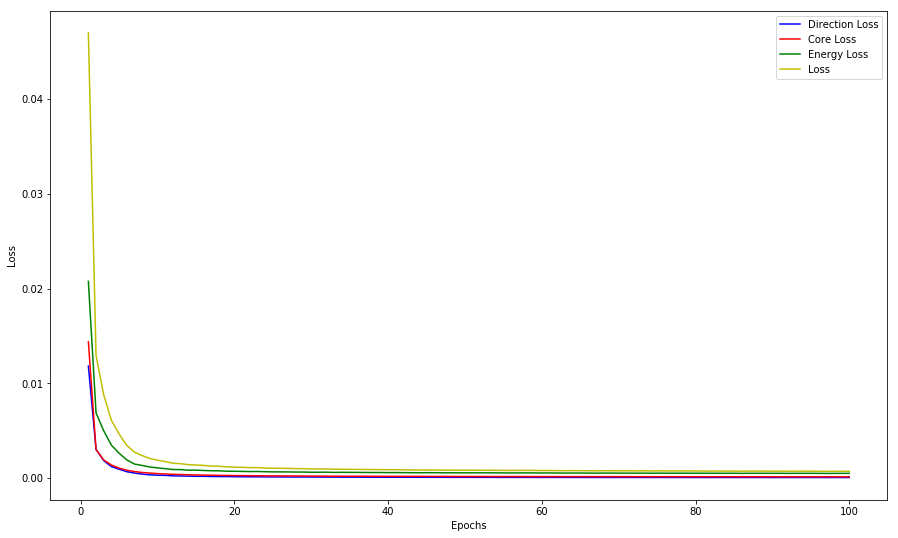

In [6]:
# TODO: plot training history - with and without weights
direction_loss = fit.history['direction_loss']
core_loss = fit.history['core_loss']
energy_loss = fit.history['energy_loss']
loss = fit.history['loss']

epochs = range(1, len(loss) + 1)
plt.figure(1, figsize=(15, 9))
plt.plot(epochs, direction_loss, 'b', label='Direction Loss')
plt.plot(epochs, core_loss, 'r', label='Core Loss')
plt.plot(epochs, energy_loss, 'g', label='Energy Loss')
plt.plot(epochs, loss, 'y', label='Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

Test loss
6.47277e-05 (direction)
1.48280e-04 (core)
4.76757e-04 (energy)
6.89765e-04 (sum)


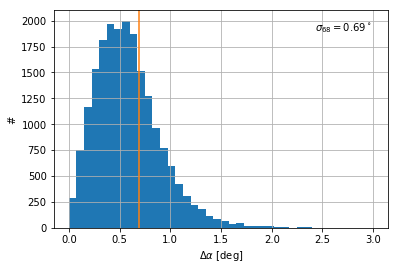

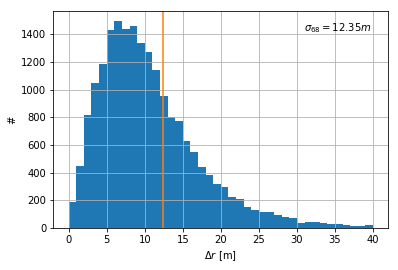

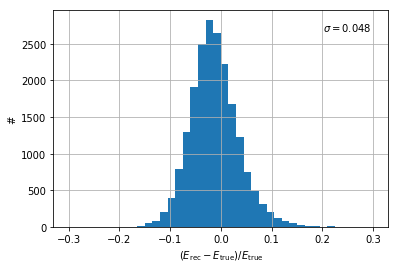

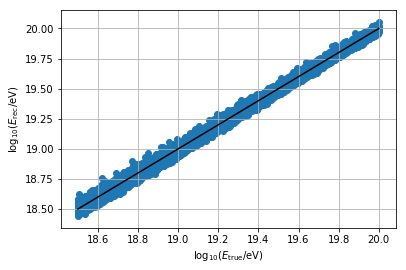

In [7]:
# ----------------------------------------------------------------------
# Evaluation - this should work as is.
# ----------------------------------------------------------------------
losses = model.evaluate(X_test, [y1_test, y2_test, y3_test], batch_size=128, verbose=0)
print('Test loss')
print('%.5e (direction)' % losses[1])
print('%.5e (core)' % losses[2])
print('%.5e (energy)' % losses[3])
print('%.5e (sum)' % losses[0])

# predict output for test set and undo feature scaling
y1p, y2p, y3p = model.predict(X_test, batch_size=128)
y2_test *= 750  # core position
y3_test += 19.25  # energy
y2p *= 750
y3p += 19.25
y3p = y3p[:, 0]  # remove unnecessary last axis

# direction
d = np.sum(y1p * y1_test, axis=1) / np.sum(y1p**2, axis=1)**.5
d = np.arccos(np.clip(d, 0, 1)) * 180 / np.pi
reso = np.percentile(d, 68)
plt.figure()
plt.hist(d, bins=np.linspace(0, 3, 41))
plt.axvline(reso, color='C1')
plt.text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel(r'$\Delta \alpha$ [deg]')
plt.ylabel('#')
plt.grid()
plt.savefig('hist-direction.png', bbox_inches='tight')

# core position
d = np.sum((y2_test - y2p)**2, axis=1)**.5
reso = np.percentile(d, 68)
plt.figure()
plt.hist(d, bins=np.linspace(0, 40, 41))
plt.axvline(reso, color='C1')
plt.text(0.95, 0.95, '$\sigma_{68} = %.2f m$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel('$\Delta r$ [m]')
plt.ylabel('#')
plt.grid()
plt.savefig('hist-core.png', bbox_inches='tight')

# energy
d = 10**(y3p - y3_test) - 1
reso = np.std(d)
plt.figure()
plt.hist(d, bins=np.linspace(-0.3, 0.3, 41))
plt.xlabel('($E_\mathrm{rec} - E_\mathrm{true}) / E_\mathrm{true}$')
plt.ylabel('#')
plt.text(0.95, 0.95, '$\sigma = %.3f$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.grid()
plt.savefig('hist-energy.png', bbox_inches='tight')

plt.figure()
plt.scatter(y3_test, y3p)
plt.plot([18.5, 20], [18.5, 20], color='black')
plt.xlabel('$\log_{10}(E_\mathrm{true}/\mathrm{eV})$')
plt.ylabel('$\log_{10}(E_\mathrm{rec}/\mathrm{eV})$')
plt.grid()
plt.savefig('scat_energy.png', bbox_inches='tight')


# Change Weights

In [8]:

model.compile(
    loss=['mse', 'mse', 'mse'],
    loss_weights=[1, 1, 1.2],  # you can give more weight to individual objectives
    optimizer=keras.optimizers.Adam(lr=1E-3))


In [9]:
fit = model.fit(X_train, [y1_train, y2_train, y3_train], 
                epochs=100, batch_size=64)

model.save('model-task3.h5')


Epoch 1/100
180000/180000 [==============================] - 39s 216us/step - loss: 8.3224e-04 - direction_loss: 7.0581e-05 - core_loss: 1.4985e-04 - energy_loss: 5.0984e-04
Epoch 2/100
180000/180000 [==============================] - 37s 208us/step - loss: 8.3481e-04 - direction_loss: 7.1582e-05 - core_loss: 1.4872e-04 - energy_loss: 5.1208e-04
Epoch 3/100
180000/180000 [==============================] - 37s 208us/step - loss: 8.2952e-04 - direction_loss: 6.7316e-05 - core_loss: 1.5022e-04 - energy_loss: 5.0999e-04
Epoch 4/100
180000/180000 [==============================] - 37s 208us/step - loss: 8.2481e-04 - direction_loss: 6.8919e-05 - core_loss: 1.4902e-04 - energy_loss: 5.0573e-04
Epoch 5/100
180000/180000 [==============================] - 37s 207us/step - loss: 8.2223e-04 - direction_loss: 6.9170e-05 - core_loss: 1.4819e-04 - energy_loss: 5.0406e-04
Epoch 6/100
180000/180000 [==============================] - 37s 208us/step - loss: 8.2596e-04 - direction_loss: 7.0434e-05 - core

180000/180000 [==============================] - 37s 207us/step - loss: 7.8014e-04 - direction_loss: 6.0346e-05 - core_loss: 1.3779e-04 - energy_loss: 4.8500e-04
Epoch 48/100
180000/180000 [==============================] - 37s 207us/step - loss: 7.7614e-04 - direction_loss: 5.9513e-05 - core_loss: 1.3730e-04 - energy_loss: 4.8277e-04
Epoch 49/100
180000/180000 [==============================] - 37s 208us/step - loss: 7.7476e-04 - direction_loss: 6.0147e-05 - core_loss: 1.3648e-04 - energy_loss: 4.8178e-04
Epoch 50/100
180000/180000 [==============================] - 37s 208us/step - loss: 7.7637e-04 - direction_loss: 6.0493e-05 - core_loss: 1.3677e-04 - energy_loss: 4.8258e-04
Epoch 51/100
180000/180000 [==============================] - 37s 207us/step - loss: 7.7027e-04 - direction_loss: 5.8493e-05 - core_loss: 1.3702e-04 - energy_loss: 4.7896e-04
Epoch 52/100
180000/180000 [==============================] - 37s 208us/step - loss: 7.7885e-04 - direction_loss: 6.2241e-05 - core_loss: 

180000/180000 [==============================] - 37s 208us/step - loss: 7.5128e-04 - direction_loss: 5.5792e-05 - core_loss: 1.2950e-04 - energy_loss: 4.7166e-04
Epoch 94/100
180000/180000 [==============================] - 37s 208us/step - loss: 7.4560e-04 - direction_loss: 5.4694e-05 - core_loss: 1.2954e-04 - energy_loss: 4.6780e-04
Epoch 95/100
180000/180000 [==============================] - 37s 208us/step - loss: 7.4340e-04 - direction_loss: 5.6176e-05 - core_loss: 1.2873e-04 - energy_loss: 4.6541e-04
Epoch 96/100
180000/180000 [==============================] - 37s 208us/step - loss: 7.4750e-04 - direction_loss: 5.5980e-05 - core_loss: 1.3033e-04 - energy_loss: 4.6766e-04
Epoch 97/100
180000/180000 [==============================] - 37s 208us/step - loss: 7.4751e-04 - direction_loss: 5.6103e-05 - core_loss: 1.2969e-04 - energy_loss: 4.6809e-04
Epoch 98/100
180000/180000 [==============================] - 37s 208us/step - loss: 7.4067e-04 - direction_loss: 5.3017e-05 - core_loss: 

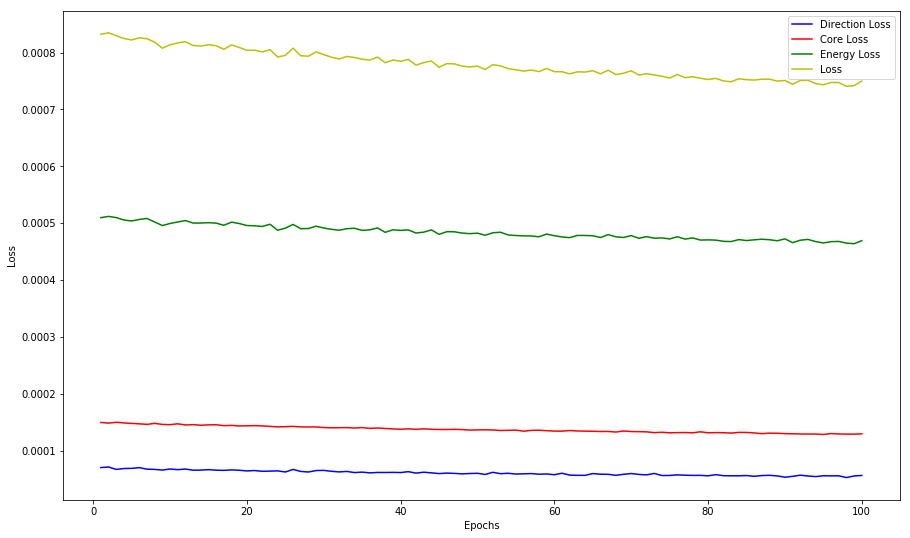

In [10]:
# TODO: plot training history - with and without weights
direction_loss = fit.history['direction_loss']
core_loss = fit.history['core_loss']
energy_loss = fit.history['energy_loss']
loss = fit.history['loss']

epochs = range(1, len(loss) + 1)
plt.figure(1, figsize=(15, 9))
plt.plot(epochs, direction_loss, 'b', label='Direction Loss')
plt.plot(epochs, core_loss, 'r', label='Core Loss')
plt.plot(epochs, energy_loss, 'g', label='Energy Loss')
plt.plot(epochs, loss, 'y', label='Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

Test loss
7.54077e-05 (direction)
1.40350e+05 (core)
3.71148e+02 (energy)
1.40796e+05 (sum)


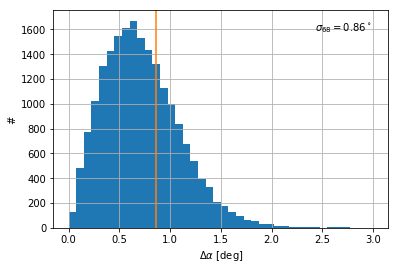

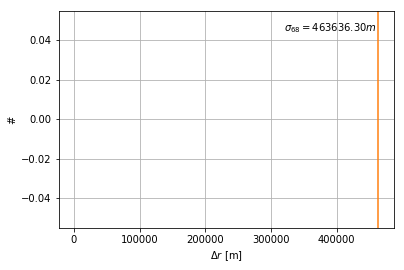

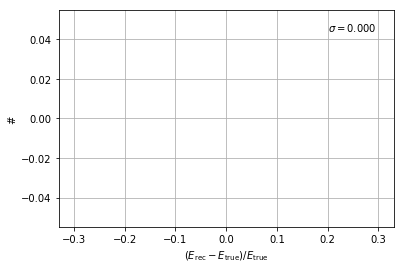

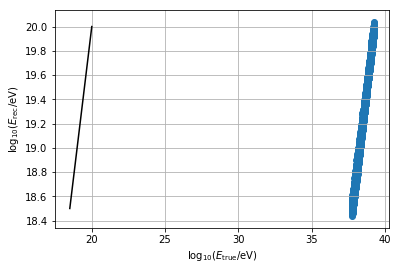

In [11]:
# ----------------------------------------------------------------------
# Evaluation - this should work as is.
# ----------------------------------------------------------------------
losses = model.evaluate(X_test, [y1_test, y2_test, y3_test], batch_size=128, verbose=0)
print('Test loss')
print('%.5e (direction)' % losses[1])
print('%.5e (core)' % losses[2])
print('%.5e (energy)' % losses[3])
print('%.5e (sum)' % losses[0])

# predict output for test set and undo feature scaling
y1p, y2p, y3p = model.predict(X_test, batch_size=128)
y2_test *= 750  # core position
y3_test += 19.25  # energy
y2p *= 750
y3p += 19.25
y3p = y3p[:, 0]  # remove unnecessary last axis

# direction
d = np.sum(y1p * y1_test, axis=1) / np.sum(y1p**2, axis=1)**.5
d = np.arccos(np.clip(d, 0, 1)) * 180 / np.pi
reso = np.percentile(d, 68)
plt.figure()
plt.hist(d, bins=np.linspace(0, 3, 41))
plt.axvline(reso, color='C1')
plt.text(0.95, 0.95, '$\sigma_{68} = %.2f^\circ$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel(r'$\Delta \alpha$ [deg]')
plt.ylabel('#')
plt.grid()
plt.savefig('hist-direction.png', bbox_inches='tight')

# core position
d = np.sum((y2_test - y2p)**2, axis=1)**.5
reso = np.percentile(d, 68)
plt.figure()
plt.hist(d, bins=np.linspace(0, 40, 41))
plt.axvline(reso, color='C1')
plt.text(0.95, 0.95, '$\sigma_{68} = %.2f m$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.xlabel('$\Delta r$ [m]')
plt.ylabel('#')
plt.grid()
plt.savefig('hist-core.png', bbox_inches='tight')

# energy
d = 10**(y3p - y3_test) - 1
reso = np.std(d)
plt.figure()
plt.hist(d, bins=np.linspace(-0.3, 0.3, 41))
plt.xlabel('($E_\mathrm{rec} - E_\mathrm{true}) / E_\mathrm{true}$')
plt.ylabel('#')
plt.text(0.95, 0.95, '$\sigma = %.3f$' % reso, ha='right', va='top', transform=plt.gca().transAxes)
plt.grid()
plt.savefig('hist-energy.png', bbox_inches='tight')

plt.figure()
plt.scatter(y3_test, y3p)
plt.plot([18.5, 20], [18.5, 20], color='black')
plt.xlabel('$\log_{10}(E_\mathrm{true}/\mathrm{eV})$')
plt.ylabel('$\log_{10}(E_\mathrm{rec}/\mathrm{eV})$')
plt.grid()
plt.savefig('scat_energy.png', bbox_inches='tight')
